# Import Dependencies

In [14]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm,tqdm_notebook
from skimage.io import imread
from IPython.display import SVG
from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.densenet import DenseNet121
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,GlobalMaxPooling2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# Custom Function For Visualizing Training Results

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


# Load Train Data and create a train test split

In [3]:
train_df = pd.read_csv('../input/train.csv')
train_df.head()

x_train,x_test,y_train,y_test = train_test_split(
    train_df['id'],
    train_df['has_cactus'],
    test_size = 0.2,
    random_state = 3)

# Load In Train and Test Images

In [4]:
X_train = []
for images in tqdm(x_train):
    img = plt.imread('../input/train/train/' + images)
    X_train.append(img)
    

X_test = []
for images in tqdm(x_test):
    img = plt.imread('../input/train/train/' + images)
    X_test.append(img)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

100%|██████████| 3500/3500 [00:04<00:00, 713.54it/s]


# Data Augmentation

In [6]:
augmentations = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.1)

augmentations.fit(X_train)

# Create The Model

In [7]:
inputs = Input((32,32,3))
model_base = DenseNet121(weights='imagenet',include_top=False,input_shape=(32,32,3))
x = model_base(inputs)
x_1 = GlobalMaxPooling2D()(x)
x_2 = GlobalAveragePooling2D()(x)
x_3 = Flatten()(x)
x = Concatenate(axis=-1)([x_1,x_2,x_3])
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1,activation='sigmoid')(x)

for layer in model_base.layers:
    layer.trainable = True

model = Model(inputs,x)
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
densenet121 (Model)             (None, 1, 1, 1024)   7037504     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1024)         0           densenet121[1][0]                
_______________________________________________________

# Callbacks

In [8]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

# Train The Model

In [10]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
    
history = model.fit_generator(
    augmentations.flow(X_train,y_train,batch_size = 16),
    steps_per_epoch=150,
    validation_steps=150,
    validation_data=(X_test,y_test),
    epochs = 50, 
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/50
150/150 [==============================] - 38s 254ms/step - loss: 0.1272 - acc: 0.9583 - val_loss: 0.8097 - val_acc: 0.9109

Epoch 00001: val_loss did not improve from 0.11707
Epoch 2/50
150/150 [==============================] - 21s 137ms/step - loss: 0.0906 - acc: 0.9725 - val_loss: 0.0721 - val_acc: 0.9666

Epoch 00002: val_loss improved from 0.11707 to 0.07207, saving model to ./base.model
Epoch 3/50
150/150 [==============================] - 20s 131ms/step - loss: 0.0951 - acc: 0.9733 - val_loss: 0.0422 - val_acc: 0.9871

Epoch 00003: val_loss improved from 0.07207 to 0.04216, saving model to ./base.model
Epoch 4/50
150/150 [==============================] - 20s 136ms/step - loss: 0.0919 - acc: 0.9738 - val_loss: 0.5829 - val_acc: 0.8166

Epoch 00004: val_loss did not improve from 0.04216

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
150/150 [==============================] - 20s 136ms/step - loss: 0.0701 - acc: 0.9775 - val

150/150 [==============================] - 20s 132ms/step - loss: 0.0446 - acc: 0.9883 - val_loss: 0.0204 - val_acc: 0.9943

Epoch 00033: val_loss did not improve from 0.01691

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
Epoch 34/50
150/150 [==============================] - 20s 134ms/step - loss: 0.0634 - acc: 0.9875 - val_loss: 0.0197 - val_acc: 0.9943

Epoch 00034: val_loss did not improve from 0.01691

Epoch 00034: ReduceLROnPlateau reducing learning rate to 7.450580950807417e-12.
Epoch 35/50
150/150 [==============================] - 20s 134ms/step - loss: 0.0229 - acc: 0.9950 - val_loss: 0.0197 - val_acc: 0.9943

Epoch 00035: val_loss did not improve from 0.01691

Epoch 00035: ReduceLROnPlateau reducing learning rate to 3.725290475403709e-12.
Epoch 36/50
150/150 [==============================] - 19s 130ms/step - loss: 0.0227 - acc: 0.9925 - val_loss: 0.0200 - val_acc: 0.9943

Epoch 00036: val_loss did not improve from 0.01691

Epoch 00036: Re

# Visualize The Training Results And Save The Weights

Weights Saved
JSON Saved


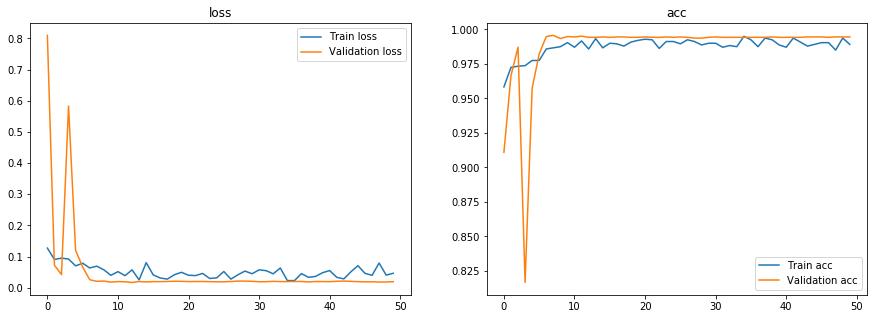

In [22]:
show_final_history(history)
model.load_weights(best_model_weights)

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")
print("JSON Saved")

# Get model Predictions

In [15]:
train_pred = model.predict(X_train, verbose= 1)
valid_pred = model.predict(X_test, verbose= 1)

train_acc = roc_auc_score(np.round(train_pred), y_train)
valid_acc = roc_auc_score(np.round(valid_pred), y_test)

confusion_matrix(np.round(valid_pred),y_test)

3500/3500 [==============================] - 2s 552us/step


array([[ 828,    9],
       [  11, 2652]])

# Load In Test Data

In [17]:
sample = pd.read_csv('../input/sample_submission.csv')
test = []
for images in tqdm(sample['id']):
    img = plt.imread('../input/test/test/' + images)
    test.append(img)

test = np.array(test)

100%|██████████| 4000/4000 [00:06<00:00, 662.55it/s]


# Create Submission For Competition

In [18]:
test = test/255
test_pred = model.predict(test, verbose= 1)

sample['has_cactus'] = test_pred
sample.head()

sample.to_csv('sub.csv', index= False)

4000/4000 [==============================] - 2s 583us/step


# TensorBoard Visualization

In [19]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


--2019-04-01 13:37:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.236.254, 34.232.181.106, 34.206.253.53, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.236.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  31.6MB/s    in 0.5s    

2019-04-01 13:37:02 (31.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://3aa834ef.ngrok.io
